### CS/ECE/ISyE 524 &mdash; Introduction to Optimization &mdash; Spring 2023 ###

### Final Course Project: Due 5/5/23

# Trajectory Optimization for Autonomous Vehicles using PID and MPC Controllers  #

#### NEVINDU BATAGODA (batagoda@wis.edu)
#### ISHAAN MAHAJAN (imahajan@wisc.edu) 


*****

### Table of Contents

1. [Introduction](#1.-Introduction)
1. [Mathematical Model](#2.-Mathematical-model)
1. [Solution](#3.-Solution)
1. [Results and Discussion](#4.-Results-and-discussion)
  1. [Optional Subsection](#4.A.-Feel-free-to-add-subsections)
1. [Conclusion](#5.-Conclusion)

## 1. Introduction ##
This project is inspired by our work as members of Wisconsin Autonomous student organization. We are part of a university team competing in the AutoDrive Challenge II competition organized by SAE International and General Motors. The goal of this competition is to build a self-driving car capable of navigating urban environmets.

As part of the control stack of the self driving car  there are three planners: 1) The High Level planner which creates a set of target waypoints to follow, 2) The Mid Level planner which generates a smooth trajectory from the waypoints and 3) A Low Level planner, which uses a feedback control algorithm to generate a target velocity and heading which is then passed into the vehicle as a throttle and a steering input.

In this project we plan to adress the trajectory optimization problem of the Mid Level planner of the Wisconsin Autonomous control stack. The theoretical foundation for our work will be based on the work done by University of Toronto during the previous iteration of the competition (AutoDrive Challenge I) (https://onlinelibrary.wiley.coma/doi/full/10.1002/rob.21958). 

The final goal is to generate a path $P = [\mathbf{X_1}...\mathbf{X_N}]$, from the way points generated from the High Level planner, $x_i = [x_i \quad y_i \quad \theta_i]$, where $\theta_i$ is the heading angle at way point $i$.

Before we start off with the Mid-Level Planner, we implement two controllers popular for autonomous navigation - <br> 
1. <b>Proportional-Integral-Derivative (PID)</b> - A feedback control mechanism that regulates a process by adjusting its inputs based on error signals. <br>
2. <b>Model Predictive Control (MPC)</b> - An advanced feedback control that uses a mathematical model to predict future behavior and optimize control actions. <br>

## 2. Mathematical model ##

A discussion of the modeling assumptions made in the problem (e.g. is it from physics? economics? something else?). Explain the decision variables, the constraints, and the objective function. Finally, show the optimization problem written in standard form. Discuss the model type (LP, QP, MIP, etc.). Equations should be formatted in $\LaTeX$ within the IJulia notebook. For this section you may **assume the reader is familiar with the material covered in class**.

Here is an example of an equation:

$$
\begin{bmatrix}
  1 & 2 \\
  3 & 4
\end{bmatrix}
\begin{bmatrix} x \\ y \end{bmatrix} =
\begin{bmatrix} 5 \\ 6 \end{bmatrix}
$$

And here is an example of an optimization problem in standard form:

$$
\begin{aligned}
\underset{x \in \mathbb{R^n}}{\text{maximize}}\qquad& f_0(x) \\
\text{subject to:}\qquad& f_i(x) \le 0 && i=1,\dots,m\\
& h_j(x) = 0 && j=1,\dots,r
\end{aligned}
$$

For some quick tips on using $\LaTeX$, see [this cheat sheet](http://users.dickinson.edu/~richesod/latex/latexcheatsheet.pdf).

## 3. Solution ##



### 3.1 PID Controller

In [1]:
using DelimitedFiles, LinearAlgebra, Plots, StatsPlots, JuMP, Ipopt


In [3]:
function search_min_distance(x::Float64, y::Float64, x_ref::Vector{Float64}, y_ref::Vector{Float64})
    # find minimum distance between current car's position and reference and give the index of that point in the reference trajectory
    dis = zeros(length(x_ref))
    min_dis = 100000
    index = -1
    for i in 1:length(dis)-1
        dis[i] = (x - x_ref[i])^2 + (y - y_ref[i])^2
        if dis[i] < min_dis
            min_dis = dis[i]
            index = i
        end
    end
    return min_dis, index
end

search_min_distance (generic function with 1 method)

In [4]:
function dynamics(x::Float64, y::Float64, v::Float64, theta::Float64, a::Float64, theta_dot::Float64)
    
    model = Model((Ipopt.Optimizer))
    set_silent(model)
    
    # Define variables
    @variable(model, x_next)
    @variable(model, y_next)
    @variable(model, v_next)
    @variable(model, theta_next)
    dt = 0.1 
    
    # Define constraints
    @NLconstraint(model, x_next == x + v * cos(theta) * dt)
    @NLconstraint(model, y_next == y + v * sin(theta) * dt)
    @NLconstraint(model, v_next == v + a * dt)
    @NLconstraint(model, theta_next == theta + (v*tan(theta_dot)) * dt)

    # Define objective function
    @NLobjective(model, Min, 0)
    
    # Solve problem
    optimize!(model)

    # Extract solution
    x_next = value(x_next)
    y_next = value(y_next)
    v_next = value(v_next)
    theta_next = value(theta_next)

    return x_next, y_next, v_next, theta_next
end

dynamics (generic function with 1 method)

In [6]:
function direction(theta_ref::Float64, theta::Float64, theta_dot::Float64)
    model = Model((Ipopt.Optimizer))
    set_silent(model)
    @variable(model, theta_dot_raw)
    @constraint(model, theta_dot_raw == theta_dot)
    @NLconstraint(model, theta_dot_raw - theta_dot * (theta - theta_ref) <= 0)
    @NLconstraint(model, theta_dot_raw + theta_dot * (theta - theta_ref) >= 0)
    @objective(model, Min, 0)
    optimize!(model)
    return value(theta_dot_raw)
    

end

direction (generic function with 1 method)

In [7]:
data = readdlm("data/input_trajectory.csv", ',', Float64)
x_ref = data[:,1]
y_ref = data[:,2]
theta_ref = zeros(length(x_ref))
for i in 1:length(x_ref)-1
    theta_ref[i] = pi + atan(y_ref[i+1]-y_ref[i], x_ref[i+1]-x_ref[i])
    
end


t_start = time()
time_span = 30
dt = 0.1
Kp = 4.0
Kd = 2.0
v = .4
accel = 0.00001
x_current = x_ref[1]
y_current = y_ref[1]
theta_current = 0.01
theta_dot_current = 0.0
min_dis_pre = 0.0
traj_x = [x_current]
traj_y = [y_current]
traj_theta = [theta_current]

for i in 1:1300
    
    min_dis, index = search_min_distance(x_current, y_current, x_ref, y_ref)
    
    theta_dot_raw = Kp * min_dis
    theta_dot_current = direction(theta_ref[index], theta_current, theta_dot_raw)
    push!(traj_theta, (theta_current - theta_ref[index]))
    theta_dot_current = theta_dot_current * Kd * abs(min_dis - min_dis_pre) # Using K_p & K_d together

    min_dis_pre = min_dis
    
    x_current, y_current, v, theta_current = dynamics(x_current, y_current, v, theta_current, accel, theta_dot_current)


    push!(traj_x, x_current)
    push!(traj_y, y_current)

end


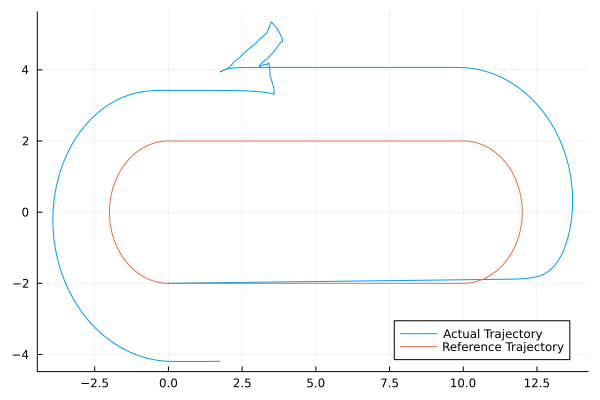

In [8]:
plot(traj_x, traj_y, label = "Actual Trajectory")

plot!(x_ref, y_ref, label = "Reference Trajectory")

## 4. Results and discussion ##

To solve the problem of finding a trajectory controller, and having it avoid obstacles, we started off with a PID controller on a bicycle model, modifying the bicycle model to fit the controller needs. However, the results did not look that great as seen in the above figure. Since a PID controller requires finding the right parameters (Kp and Kd in our case), it involves a lot of trial and error, and was complex to do all of it within Julia. We therefore decided to build on this work we had to further implement a MPC controller, which theoretically should provide much better results than a PID controller. 

## 5. Conclusion ##

Summarize your findings and your results, and talk about at least one possible future direction; something that might be interesting to pursue as a follow-up to your project.